# SLT-CE-1: Sampling

In this coding exercise we will test various Markov Chain Monte Carlo (MCMC) sampling procedures [1] introduced during the tutorial session. We will first tackle the image reconstruction problem followed by the traveling salesman problem.

## Task (image reconstruction problem)


Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one needs to recover the original through denoising. To do so we will use the prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from physics as explained in section 8.3.3 of [2]. An undirected graphical model is designed to model (i) the adherence of the reconstruction to the observed noisy image and (ii) the correlation between neighboring pixels. We are interested in recovering a single image, the most likely one, with respect to the underlying distribution i.e. we do MAP inference to discover the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 
[0] [SLT Tutorial 3 on Sampling](https://ml2.inf.ethz.ch/courses/slt/tutorials/tutorial03-sampling.pdf)

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is the value of the i-th pixel, the Ising model tries to find a denoised image $x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x|y) = - \frac{\beta}{2} \sum_{i} \frac{x_i}{\lvert N_i\rvert}\sum_{j \in N_i} x_j - \mu \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel neighbourhood $N_i$ usually involves $\lvert N_i\rvert=$ 4 or 8 surrounding pixels. In this exercise we consider only the 4 pixel neigbourhood (up, down, left and right pixels). The undirected probabilistic graphical model from where the energy function $E(x|y)$ is derived is explained in more detail in [2].

 <h2> Setup </h2>

We start by importing necessary python packages.

In [33]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time

from skimage.transform import resize
from scipy.signal import fftconvolve
from sklearn.metrics import hamming_loss

from scipy.optimize import minimize_scalar
from multiprocessing import cpu_count
from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')

In [34]:
def flower(size=None, p=0.3):
    """Load image data for denoising
    
    Args:
        size (tuple): image size, default (300,300)
        p (float): noise fraction in [0,1]
        
    Returns:
        noisy: noisy image
        img: ground truth image
    """
    img = mpimg.imread("flower.png") # Load image
    
    # Binarize image
    img[img > 0.5] = 1
    img[img <= 0.5] = -1
    
    # Resize image 
    if size is not None:
        img = resize(img, size)
        img[img > 0] = 1
        img[img <= 0] = -1
    
    np.random.seed(13)

    flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

    noisy = flip * img
    
    return noisy, img

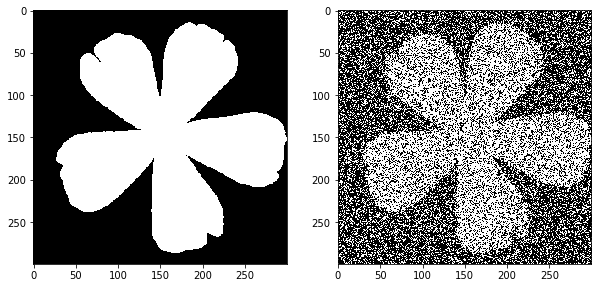

In [35]:
noisy, img = flower()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(noisy,cmap='gray')
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Shortly describe the following sampling procedures, and provide the key formulas. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>


For the following discussion, let $\mathcal{C}$ denote a hypothesis class and $p(c)$ a probability distribution over $\mathcal{C}$ for which we want to (efficiently) generate samples, but which is intractable such that special methods are required, e.g. MCMC-sampling. 

Basis of the MCMC-sampling procedure is the following result (cf. Theorem 6 in the lecture notes):

Suppose we have a parametrized family $\{\pi(\cdot|c)\}_{c\in\mathcal{C}}$ of transition probabilities such that the following holds:
1. The associated graph $G_{\pi}$ is connected.
2. There is an edge for any vertex $c\in G_{\pi}$ to itself, i.e. $\pi(c|c)>0$ for any $c\in\mathcal{C}$.
3. Detailed balance is satisfied, i.e. $\pi(c'|c) p(c) = \pi(c|c') p(c')$ for any two $c, c' \in\mathcal{C}$.

Then the Markov chain has $p$ as its stationary distribution, i.e. $\lim_{t\to\infty} P(C_t = c) = p(c)$ for any $c\in\mathcal{C}$ and where $C_t$ is a sequence of random variables satisfying $C_t \sim \pi(\cdot|C_{t-1})$.

The idea of the following algorithms is now to construct a family of conditional distributions $\{\pi(\cdot|c)\}_{c\in\mathcal{C}}$ satisfying the conditions of the theorem and then draw samples $C_t \sim \pi(\cdot|C_{t-1})$, which eventually will have a distribution close to $p$ and which therefore can be used to approximate the intractable distribution $p$ that we are interested in. Additionally, the intractability of the distribution $p$ is supposed to be caused by its normalization, i.e. we assume that there is some tractable function $f(c)$ proportational to $p(c)$. 

Concretely,

- **Metropolis**: This algorithm is a special case of the Metropolis-Hastings (see next) algorithm, in which we have a *symmetric* proposal distribution, i.e. $q(c|c') = q(c'|c)$. The accepting probability then simplifies to $A(c',c) = min\{ 1, \frac{f(c')}{f(c)}\}$.

- **Metropolis-Hastings**: 
First, one chooses an arbitrary sample $c_0$ and defines a family of *proposal distributions* $\{q(\cdot|c): c\in\mathcal{C} \}$ such that the associated graph $G_{q}$ is connected and $q(c|c)>0$ for any $c\in\mathcal{C}.$ At time step $t$, we sample a *candidate* $c_t\sim q(\cdot|c_{t-1})$. Then an *accepting probability* is calculated:
$$A(c_t,c_{t-1}) = min\{ 1, \frac{f(c_t)q(c_{t-1}|c_t)}{f(c_{t-1})q(c_t|c_{t-1})} \},$$ which reflects a trade-off between transitioning to more probable vertices (reflected by $\frac{f(c_t)}{f(c_{t-1})}$) and not getting stuck (reflected by $\frac{q(c_{t-1}|c_t)}{q(c_t|c_{t-1})}$). With probability $A(c_t,c_{t-1})$, we keep the candidate $c_t$ as our new sample and otherwise we set it equal to the previous sample $c_t \leftarrow c_{t-1}$

- **Simulated Annealing**: Simulated annealing is an extension of the Metropolis-Hastings algorithm in the case where the considered distribution $p_T$ has a so-called *temperature* hyperparameter, e.g. the Gibbs-distribution. It deals with the trade-off that for $T$ large the distribution is rather uniform and thus the solution space will be widely searched, but bad models are barely discriminated and the converse for $T$ small. In Simulated Annealing, we therefore start with a sufficiently large temperature $T_0$ and generate samples according to the MH-Algorithm. We then reduce the temperature $T_1 < T_0$, generate MH-samples again and so forth until we have reached a certain minimal temperature $T_N$



<p style="background-color:#adebad;">
    Implement the energy function introduced in the model section of the notebook.<br>
    <b> (!)</b> Deliberately implement a naive solution, which explicitly performs (nested) loops to compute the sums. 
    </p>

In [36]:
def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', which corresponds to the vector y in the model.

    Args:
        img_estimate (np.ndarray): estimated image matrix
        img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
        energy (float): energy of the estimate given observation
    """
    height = img_estimate.shape[0]
    width = img_estimate.shape[1]
    
    E = 0
    for i in range(height):
        for j in range(width):
            E1_nbhd = 0 
            E1_nbhd += img_estimate[i-1,j] if i > 0 else 0  # left neighbour
            E1_nbhd += img_estimate[i,j-1] if j > 0 else 0  # down
            E1_nbhd += img_estimate[i+1,j] if i < (height -1) else 0  # right
            E1_nbhd += img_estimate[i,j+1] if j < (width - 1) else 0  # up
            
            E1 = - beta/2 * img_estimate[i,j] * E1_nbhd/4 # first sum of energy function
            E2 = - mu * img_estimate[i,j] * img_noisy_observation[i,j]
            E += E1 + E2
    
    return E 

<p style="background-color:#adebad;">Make sure to get the correct result:</p>

In [37]:
assert np.isclose(energy(*flower()), -145700.75)

<p style="background-color:#adebad;">Implement metropolis sampling.<br>
<b>(!)</b> Deliberately implement a naive solution, which loops over each pixel, attempts a flip, measures the energy before and after, and then decides whether to accept the flip, or not. Use the naive energy function from before.
</p>

In [38]:
def metropolis(img_noisy_observation, epochs,  T=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using energy.

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of the simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    prob = []
    flip = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for cnt, idx in enumerate(np.random.permutation(n_pixels)):
            
            print("Finished {:6.2f}% of epoch {}".format(cnt/n_pixels * 100, e+1), end="\r")
            
            coord = np.unravel_index(idx, [height, width]) # determine pixel
            e_1 = energy(noisy_img, estimate)
            attempt = estimate.copy()
            attempt[coord] = -1*estimate[coord]
            if np.array_equal(estimate, attempt): 
                print ("equal") 
                return
            e_2 = energy(noisy_img, attempt)
            
            if e_2 <= e_1:
                estimate = attempt
            else:
                p = np.exp((e_1 - e_2) / T)
                u = np.random.uniform()
                if u<= p: 
                    estimate = attempt
    
        energies.append(energy(noisy_img, estimate))
            
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Evaluate your implemented metropolis algorithm, using the provided evaluation function.<br>
    The energy should decrease over epochs. The reconstructed image should be a denoised version of the noisy image.
    </p>

In [39]:
def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
        method (function pointer): sampling method
        img_noisy_observation (np.ndarray): noisy image matrix
        img_original (np.ndarray): original image matrix
        epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
        T (float): The positive temperature of the simulation
    """

    start_time = time.time()
    img_estimate, energies = method(img_noisy_observation, epochs, T)
    execution_time = time.time() - start_time

    if not surpress:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

        ax1.plot(energies, marker="x")
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('energy')

        ax2.imshow(img_estimate, cmap='gray')
        ax2.set_title('Reconstruction')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

        ax3.imshow(img_noisy_observation, cmap='gray')
        ax3.set_title('Input')
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

        plt.show()
    
    return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())

<p style="background-color:#adebad;">
    The naive implementation is incredibly slow, so we use a downsampled image for evaluation.
</p>

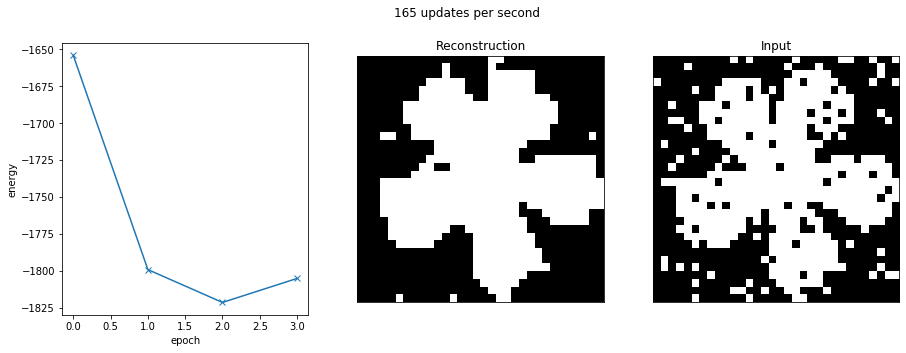

In [40]:
E_metro = evaluate_ising(metropolis, *flower(size=(32,32), p=0.1), epochs=3)

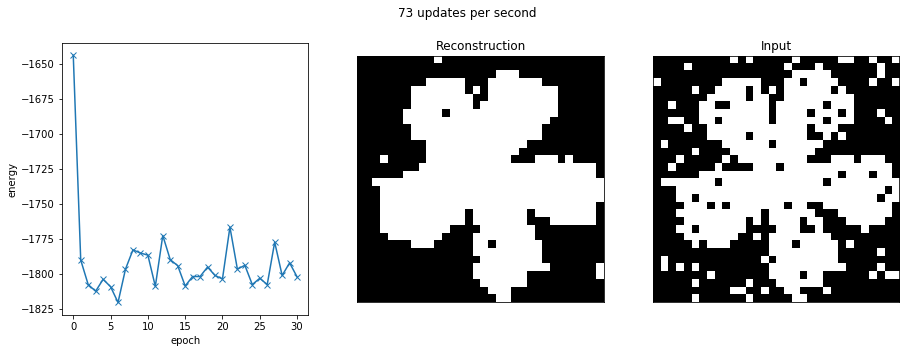

(-1802.0, 0.0498046875)

In [9]:
evaluate_ising(metropolis, *flower(size=(32,32), p=0.1), epochs=30)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
We are now considering a different problem. We want to solve the <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem">traveling salesman problem</a> for N=532 major cities in the USA.
</p>

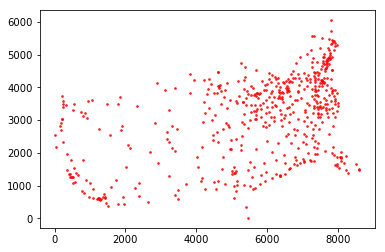

In [10]:
coordinates = pd.read_csv("cities.csv", names=['x', 'y'], sep=';', index_col=False)
coordinates = np.asarray(coordinates)  # Nx2 array containing the coordiantes of the cities
plt.scatter(coordinates[:,0], coordinates[:,1], s=3, c="r", alpha=0.75)
plt.show()

<p style="background-color:#adebad;">
Implement the distance function for the TSP:
</p>

In [11]:
def distance(coordinates, route=None):
    """Calculate travel distance.
    
    If no route is given, assumes that coordinates are travelled in order,
    starting at the first entry, and connecting the last entry again with the first.
    
    Args:
        coordinates (np.ndarray): route coordinates (assume in units of meters)
        route: permutation of coordinate order
        
    Returns:
        float: traveled distance in units of kilometers
    """
     
    if route is not None:
        coordinates = coordinates[route]
           
    x = np.diff(np.hstack((coordinates[:,0], coordinates[0,0]))) 
    y = np.diff(np.hstack((coordinates[:,1], coordinates[0,1])))
    dist = np.vstack((x,y))**2
    dist = np.sum(dist, axis=0)**(1/2)
    dist = np.sum(dist) / 1000.0
        
    return dist

<p style="background-color:#adebad;">
Make sure it returns the correct value:
</p>

In [12]:
assert np.isclose(distance(coordinates), 978.3514183630234)

In [13]:
def evaluate_tsp(method, coordinates, epochs=1):
    """Evaluate sampling method on coordinates
    
    Args:
        method (function pointer): sampling method
        coordinates (np.ndarray): city coordinates, shape Nx2
        epochs (int): number of epochs to run the sampling
    """
    np.random.seed(7)
    N = coordinates.shape[0]
    route = np.random.permutation(N)
 
    start_time = time.time()
    route, distances = method(coordinates, route, epochs)
    execution_time = time.time() - start_time

    if not (np.sort(route) == range(N)).all():
        raise ValueError("Returned route is not valid!")

    x, y = coordinates[route, 0], coordinates[route, 1]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(distances, marker="o", markersize=3)
    plt.plot([0, len(distances)], [27686/1000,27686/1000], c="green") # best known solution
    plt.grid(axis="y")
    
    plt.subplot(122, xticks=[], yticks=[])
    plt.plot(x, y, alpha=0.5, c="blue", marker="o", markerfacecolor="red", markersize=3, linewidth=1)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], alpha=0.5, c="blue", linewidth=1)
    
    plt.show()

<p style="background-color:#adebad;">
First, solve the traveling salesman problem with metropolis, and then with simulated annealing. <br>
We consider all permutations of $(1,\dots,N)$ as the solution space, so one route corresponds to one permutation. <br>
As proposals use transpositions instead of pixel flips. <br>
More precisely, pick a random index $i$, and exchange it with its successor, i.e. $(x_1,\dots,x_i, x_{i+1},\dots,x_N) \rightarrow (x_1,\dots,x_{i+1}, x_{i},\dots,x_N)$.<br>
    Keep in mind, that TSP goes in a cycle, so the successor of N is 1.
</p>

In [14]:
def metropolis_tsp(coordinates, route=None, epochs=1, T=1):
    """Metropolis for TSP

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        epochs (int): number of loops through all cities.
        T (float): Temperature of simulation

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))
    for e in range(epochs):
        
        for idx in np.random.permutation(N):
            
            dist_1 = distance(coordinates, route)
            attempt = route.copy()
            
            if idx == N-1:     # transposition (0,N-1)
                temp = attempt[0]
                attempt[0] = attempt[idx]
                attempt[idx] = temp
            else:
                temp = attempt[idx+1]
                attempt[idx+1] = attempt[idx]
                attempt[idx] = temp
            
            dist_2 = distance(coordinates, attempt)
            if dist_2 <= dist_1:
                route = attempt
            else:
                p = np.exp((dist_1 - dist_2) / T)
                s = np.random.binomial(1, p, 1)
                if s == 1: route = attempt
        
        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your metropolis algorithm for the traveling salesman problem.
</p>

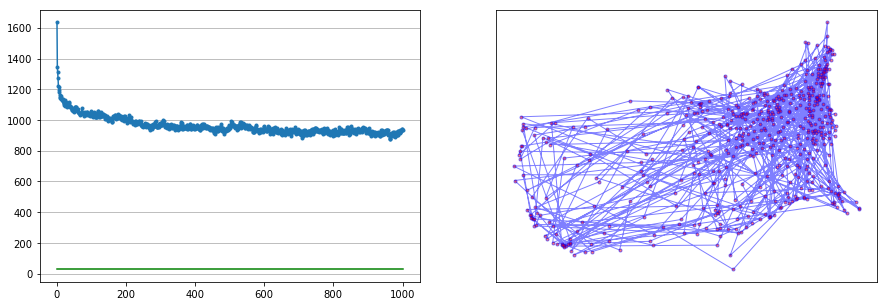

In [15]:
evaluate_tsp(metropolis_tsp, coordinates, epochs=1000)

In [16]:
def simulated_annealing(coordinates, route=None, epochs=1, T=20.0, eta=0.995):
    """Simulated Annealing for TSP

    T(n) = T * eta**n

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        route (array): inital route
        epochs (int): number of loops through all cities.
        T (float): Initial temperature
        eta (float): Exponential cooling rate

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))

    for e in range(epochs):
        for idx in np.random.permutation(N):
            
            dist_1 = distance(coordinates, route)
            attempt = route.copy()
            
            if idx == N-1:     # transposition (0,N-1)
                temp = attempt[0]
                attempt[0] = attempt[idx]
                attempt[idx] = temp
            else:
                temp = attempt[idx+1]
                attempt[idx+1] = attempt[idx]
                attempt[idx] = temp
            
            dist_2 = distance(coordinates, attempt)
            if dist_2 <= dist_1:
                route = attempt
            else:
                p = np.exp((dist_1 - dist_2) / T)
                u = np.random.uniform()
                if u <= p:  
                    route = attempt

        T = T * eta # reduce the temperature
        
        distances.append(distance(coordinates, route))
        

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your simulated annealing algorithm for the traveling salesman problem.
</p>

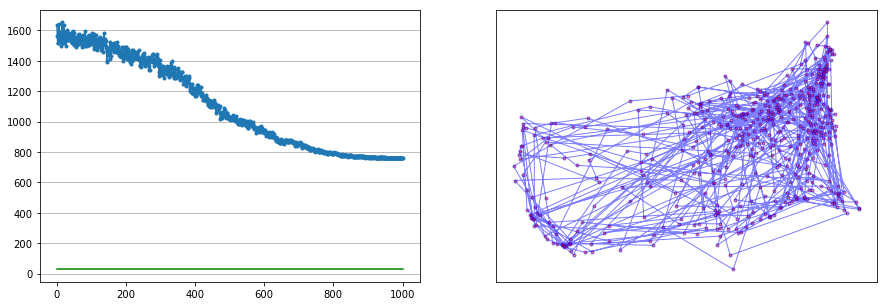

In [17]:
evaluate_tsp(simulated_annealing, coordinates, epochs=1000)

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Optimize the calculation of the naive metropolis for the Ising problem by taking into account that the energy change caused by a single flip depends only on the affected pixel's value, and its neighborhood.<br>
    More precisely, implement the function local_energy_change, and use it in the method local_metropolis.
</p>

In [18]:
def local_energy_change(noisy, estimate, i, j, beta, mu):
    """
    
    Local energy difference between unflipped and flipped pixel i,j 
    
    Args:
        noisy: noisy reference image
        estimate: current denoising estimate
        i,j: Position of pixel
    
    Returns:
        float: local energy difference when pixel i,j is flipped 
    """
    height = estimate.shape[0]
    width = estimate.shape[1]
    
    flip = estimate.copy()
    
    dE = 0  # initiliaze local energey
    
    # need if-conditions to deal with edge cases
    if i < height-1: dE += estimate[i,j] * estimate[i+1,j]
    if i > 0: dE += estimate[i,j] * estimate[i-1,j]
    if j < width-1: dE += estimate[i,j] * estimate[i,j+1]
    if j > 0: dE += estimate[i,j] * estimate[i,j-1]

    dE = beta/2 * dE        
    dE += 2 * mu * noisy[i,j] * estimate[i,j]
    
    return dE



def local_metropolis(img_noisy_observation, epochs, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using local_energy_change 

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for cnt, pix in enumerate(np.random.permutation(n_pixels)):
            
            coord = np.unravel_index(pix, [height, width]) # determine pixel
            e_delta = local_energy_change(noisy_img, estimate, coord[0], coord[1], beta, mu)
            
            if e_delta <= 0:
                estimate[coord] = -1*estimate[coord]
            else:
                p = np.exp(-e_delta / T)
                u = np.random.uniform()
                if u<= p:  
                    estimate[coord] = -1*estimate[coord]          
            
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    We run two evaluations, one for the small image, and one on the full image.
    </p>

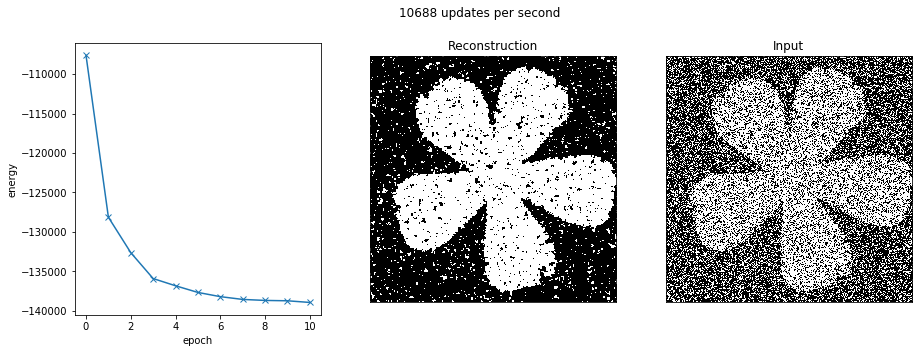

(-138945.75, 0.07433333333333333)

In [19]:
E_local = evaluate_ising(local_metropolis, *flower(size=(32,32), p=0.1), epochs=3, surpress=True);
evaluate_ising(local_metropolis, *flower(), epochs=10)

<p style="background-color:#adebad;">
    Make sure, metropolis and local_metropolis are equivalent:
    </p>

In [20]:
E_metro

(-1812.25, 0.0419921875)

In [21]:
assert E_metro == E_local

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    We can speed up metropolis for the Ising model even further by using vectorized operations, i.e. using operations on arrays instead of looping over pixels.<br>
    Implement checkerboard_metropolis, which alternatingly updates two independent sub-grids at once.
    Your final code must have only one for-loop, namely over epochs (not counting the loop over the two grids). Use fftconvolve to compute the neighborhood term of the energy difference.
    </p>

In [22]:
kernel = np.array([[0,1,0],[1,0,1],[0,1,0]])
kernel = np.array([[1,1,1],[1,1,1],[1,1,1]])
np.round(fftconvolve(kernel, kernel, mode='same'),0)

array([[4., 6., 4.],
       [6., 9., 6.],
       [4., 6., 4.]])

In [23]:
def checkerboard(shape):
    grid_1 = np.indices(shape).sum(axis=0) % 2
    grid_2 = np.ones(shape) - grid_1
    return [grid_1, grid_2]

In [24]:
checkerboard([5,5])

[array([[0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0]]), array([[1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0.],
        [1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0.],
        [1., 0., 1., 0., 1.]])]

In [25]:
def checkerboard_energy_change(noisy_img, estimate, grid, beta, mu):
    """Compute energy change when flipping pixels in grid
    
    When using the 4-neighborhood, a 2D image can be separated in two
    independent grids, hence the name checkerboard.
    All the pixels in one grid can be updated simultaneously, because they
    are independent. Using this property, we can improve computational
    efficiency by using vectorized operations instead of loops.
    
    Args:
        noisy_img: Noisy reference image
        estimate: Current image reconstruction
        grid: Flat array or list of grid indices.
    
    Returns:
        numpy.array: Energy change for each pixel in grid,
            same size as grid.
    
    """
    
    kernel = np.array([[0,1,0],[1,0,1],[0,1,0]]) * (beta/2)
    dE = fftconvolve(estimate, kernel, mode='same')
    dE = np.multiply(estimate, dE + 2 * mu * noisy_img)
    dE = np.multiply(dE, grid)
    
    return dE

In [26]:
def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    Alternatingly update two independent grids

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number

    n_pixels = img_noisy_observation.size
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    shape = estimate.shape
    height = shape[0]
    width = shape[1]
    grids = checkerboard(shape)  # see function above
    
    energies = []
    
    for e in range(epochs):

        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for grid in grids:
            # compute local checkerboard energy change for grid
            dE = checkerboard_energy_change(noisy_img, estimate, grid, beta, mu)

            # compute flip/acceptance probability
            p = np.exp(-dE / T)
            p = np.clip(p,0,1) # cap p at 1 (i.e. when dE<0)
            
            # sample uniform, if u<=p the flip -1 (corresponds to Ber(p))
            u = np.random.uniform(0, 1, n_pixels).reshape(width, height)

            flips = np.multiply((u <= p),grid) # make sure to only flip on grid
            flips = 1-2*flips                  # transform to get the -1 for flips, and +1 for non-flip
    
            estimate = np.multiply(flips, estimate) # flip the estimate 
        
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)


<p style="background-color:#adebad;">
    Run the checkerboard_metropolis:
    </p>

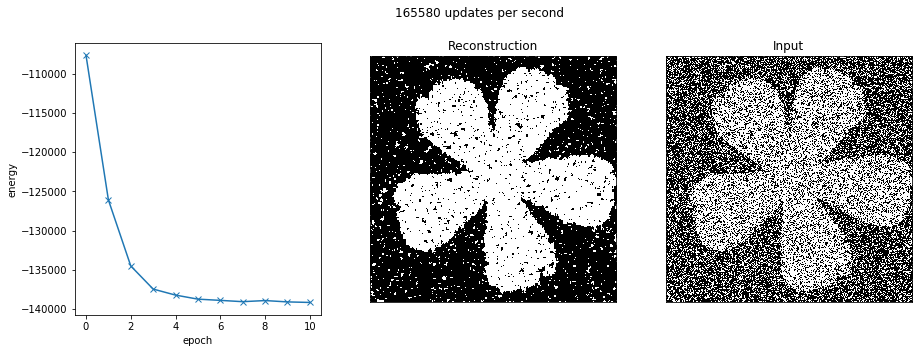

(-139188.25, 0.07151111111111111)

In [27]:
evaluate_ising(checkerboard_metropolis, *flower(), epochs=10)

<p style="background-color:#adebad;">
    Run the experiment below, and explain the observed behavior!
    </p>

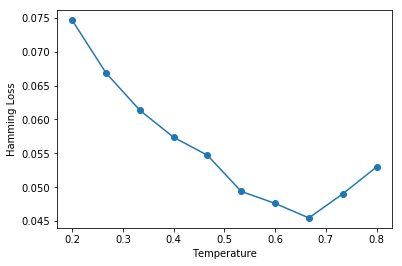

In [28]:
Trange = np.linspace(0.2,0.8,10)
loss = [evaluate_ising(checkerboard_metropolis, *flower(), epochs=10, T=T, surpress=True)[1]
         for T in np.linspace(0.2,0.8,10)]

plt.plot(Trange, loss, marker="o")
plt.ylabel("Hamming Loss")
plt.xlabel("Temperature")
plt.show()

<p style="background-color:#F9E9C6;">
As mentionned in the brief description of the Simulated Annealing algorithm: There is a trade-off when choosing a temperature $T$. For $T$ large, the algorithm will search rather quickly through the solution space (the acceptance probability will be low) and it will also much quicker leave (a neighborhood of ) a (local) minima. Conversely, for $T$ small, the algorithm is "conservative" and will move rather slowly through the solution space and more easily get stuck in some (bad) local minimum. This trade-off is reflected in the "U-shape" of above graph. According to the graph, a good choice of $T$ would be around 0.6.   
<p\>

<p style="background-color:#adebad;">
Run the experiment below, and explain the observed behavior!
</p>

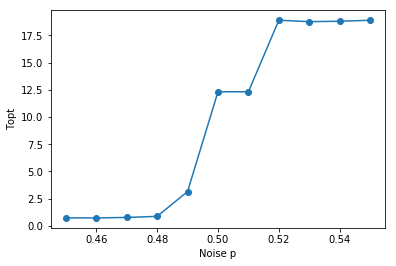

In [29]:
def find_Topt(p):
    f = lambda T: evaluate_ising(checkerboard_metropolis, *flower(p=p), epochs=10, T=T, surpress=True)[1]
    result = minimize_scalar(f, options={"xatol": 0.001}, bounds=(0, 20), method="bounded")
    return result.x

prange = np.arange(0.45, 0.55, 0.01)
with Pool(cpu_count()) as pool:
    Topt = pool.map(find_Topt, prange)
    
plt.plot(prange, Topt, marker="o")
plt.ylabel("Topt")
plt.xlabel("Noise p")
plt.show()

<p style="background-color:#F9E9C6;">
Note that the optimal $T$ increases significantly around a noise level of $p=0.50$. 
With such a high level of noise, the algorithm seems to struggle to use the signal from the input image efficiently. It thus 'desperately' prefers a larger temperature in order to be able to move more quickly through the solution space.
<p\>

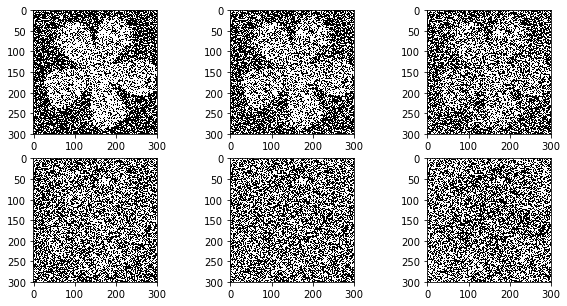

In [30]:
plt.figure(figsize=(10,5))

noisy, _ = flower(p=.3)
plt.subplot(231)
plt.imshow(noisy, cmap='gray')

noisy, _ = flower(p=.35)
plt.subplot(232)
plt.imshow(noisy,cmap='gray')

noisy, _ = flower(p=.4)
plt.subplot(233)
plt.imshow(noisy, cmap='gray')

noisy, _ = flower(p=.45)
plt.subplot(234)
plt.imshow(noisy,cmap='gray')

noisy, _ = flower(p=.5)
plt.subplot(235)
plt.imshow(noisy, cmap='gray')

noisy, _ = flower(p=.55)
plt.subplot(236)
plt.imshow(noisy,cmap='gray')

plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Implement a more sophisticated proposal distribution, which is more appropriate for TSP than simple transpositions. <br>
Consider your idea successful, if the travel distance goes at least below 300.<br>
Moreover, make sure that your algorithm fullfills detailed balanced by using the Metropolis-Hastings acceptance probability:<br>
    $p_{accept}=\min(\frac{p(x\rightarrow y)}{p(y\rightarrow x)}e^{-\frac{\Delta E}{T}}$, 1)
</p>

<p style="background-color:#F9E9C6;">
The issue with the previous implementation is that simple transpositions yield only very small changes in the solution space. Thus, convergence becomes very slow. In the following, we will not just flip two cities, but permutate a random continuous range (resp. its complement) of the current route. In a sense, we will explore the solution space with bigger steps and we can confirm below that convergence is indeed speed-up considerably.
</p>

In [31]:
def transform_perm(perm, idx):
    
    """
    We randomly select a continuous range of the permutation and 
    either reverse the range itself or the its complement
    
    Input: Permutation
    Output: Transformed permutation
    
    Example: idx = 3, i = 8
    perm = [7 6 9 0 2 3 8 5 1 4]
    output = [9 6 7 0 2 3 8 5 4 1]
    
    """
    
    n = len(perm)
    i = np.random.randint(0, n)
    temp = perm.copy()

    if i <= idx:  # flip the range i:idx 
        temp[i:idx] = perm[i:idx][::-1]
    else:  # flip the complement of the range i:idx 
        temp[:idx] = perm[:idx][::-1]
        temp[i:] = perm[i:][::-1]
        
    return temp
    

In [32]:
def myfancyalgorithm(coordinates, route=None, epochs=1, T=300.0, eta=0.90):
    
    np.random.seed(7)
    N = coordinates.shape[0]
  
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))

    for e in range(epochs):
        for idx in np.random.permutation(N):
            
            dist_1 = distance(coordinates, route)
            # we transform the current route according to the function above
            attempt = transform_perm(route, idx) 
            dist_2 = distance(coordinates, attempt)
            
            if dist_2 <= dist_1:
                route = attempt
            else:
                p = np.exp((dist_1 - dist_2) / T)
                u = np.random.uniform()
                if u <= p: route = attempt
                
        T = T * eta # reduce the temperature
        distances.append(distance(coordinates, route))
        
    return np.asarray(route), np.asarray(distances) 

<p style="background-color:#adebad;">
Evaluate your more sophisticated algorithm for the traveling salesman problem.
</p>

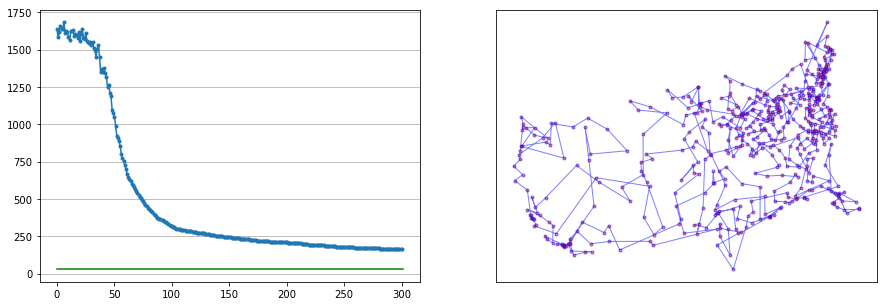

In [33]:
evaluate_tsp(myfancyalgorithm, coordinates, epochs=300)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.